### TextCNN文本分类器

本程序使用pytorch构建并训练了可用于文本分类的TextCNN模型,请确认dataset目录中已存在kfold程序生成的csv文件,且已下载预训练词向量

附录中展示了测试过程中曾使用过的LSTM模型与较为朴素的TextCNN模型的代码

导入用到的库

In [1]:
import pandas as pd #用于数据处理
import numpy as np #用于矩阵计算
import torch #用于搭建及训练模型
import time #用于训练计时
import random #用于生成随机数
import os #用于文件操作
from torchtext import data #用于生成数据集
from torchtext.vocab import Vectors #用于载入预训练词向量
from tqdm import tqdm #用于绘制进度条
from torchtext.data import Iterator, BucketIterator #用于生成训练和测试所用的迭代器
import torch.nn as nn #用于搭建模型
import torch.optim as optim #用于生成优化函数
from matplotlib import pyplot as plt #用于绘制误差函数

torch.manual_seed(19260817) #设定随机数种子
torch.backends.cudnn.deterministic = True #保证可复现性

def tokenize(x): return x.split() #分词函数,后续操作中会用到

设定所用的训练&测试数据

定义MyDataset类并生成训练和测试所用数据集

In [2]:
TEXT = data.Field(sequential=True, tokenize=tokenize, fix_length=50) #设定句长为50
LABEL = data.Field(sequential=False, use_vocab=False)

# 定义Dataset类
class Dataset(data.Dataset):
    name = 'Dataset'
    def __init__(self, path, text_field, label_field):
        fields = [("text", text_field), ("category", label_field)]
        examples = []
        csv_data = pd.read_csv(path) #从csv文件中读取数据
        print('read data from {}'.format(path))
        for text, label in tqdm(zip(csv_data['text'], csv_data['category'])):
            examples.append(data.Example.fromlist([str(text), label], fields))
        super(Dataset, self).__init__(examples, fields) #生成标准dataset

载入训练和测试所用的数据集

In [3]:
dataset_id = 2 #选择所使用的dataset组合
train_path = 'dataset/Train'+str(dataset_id)+'UTF8.csv' #训练数据文件路径
test_path = 'dataset/Test'+str(dataset_id)+'UTF8.csv' #测试数据文件路径
train = Dataset(train_path, text_field=TEXT, label_field=LABEL) #生成训练集
test = Dataset(test_path, text_field=TEXT, label_field=LABEL) #生成测试集

0it [00:00, ?it/s]

read data from dataset/Train2UTF8.csv


12274it [00:00, 77603.33it/s]
1364it [00:00, 56758.51it/s]

read data from dataset/Test2UTF8.csv


使用预训练词向量构建映射关系及权重矩阵

In [4]:
if not os.path.exists('.vector_cache'): #建立缓存文件夹以存储缓存文件
    os.mkdir('.vector_cache')
vectors = Vectors(name='weibo') #使用微博数据集所训练好的词向量
TEXT.build_vocab(train, vectors=vectors, unk_init = torch.Tensor.normal_, min_freq=5) #构建映射,设定最低词频为5
weight_matrix = TEXT.vocab.vectors #构建权重矩阵

定义搭建模型使用的TextCNN类

In [5]:
class TextCNN(nn.Module):
    def __init__(self, window_sizes, vocab_size = len(TEXT.vocab), pad_idx = TEXT.vocab.stoi[TEXT.pad_token], embedding_dim=300, text_len=50, output_dim=9, feature_size=100):
        super().__init__() #调用nn.Module的构造函数进行初始化
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx) #使用embedding table构建语句到向量的映射
        self.embedding.weight.data.copy_(weight_matrix) #载入由预训练词向量生成的权重矩阵
        self.convs = nn.ModuleList([ #定义所使用的卷积操作
                nn.Sequential(nn.Conv1d(in_channels=embedding_dim, out_channels=feature_size, kernel_size=h,), #1维卷积
                              nn.BatchNorm1d(num_features=feature_size),  #正则化
                              nn.ReLU(), #ReLU
                              nn.MaxPool1d(kernel_size=text_len-h+1)) #Max Pooling
                              for h in window_sizes])
        self.fc = nn.Linear(in_features=feature_size*len(window_sizes),out_features=9) #全连接层
        self.dropout = nn.Dropout(0.4) #dropout
        
    def forward(self, text): #前向传播
        embedded = self.embedding(text)
        embedded = embedded.permute(1, 2, 0) #[]
        out = [conv(embedded) for conv in self.convs]
        out = torch.cat(out, dim=1) #纵向拼接卷积操作输出的矩阵
        out = out.view(-1, out.size(1)) #将矩阵拉直为向量
        #out = self.dropout(out)
        y = self.fc(out) #通过全连接层处理获得预测类别
        return y #返回预测值

设定batch size并生成训练与测试所用的迭代器

In [6]:
batch_size = 256
train_iter = BucketIterator(dataset=train, batch_size=batch_size, shuffle=True)
test_iter = Iterator(dataset=test, batch_size=batch_size, shuffle=True)

模型训练函数

传入参数: 训练轮数

In [7]:
def fit(num_epoch=60):
    torch.cuda.empty_cache() #清空gpu缓存
    start = time.time() #记录训练开始时间
    losses = [] #用于记录训练过程中loss
    acc = [] #用于记录训练过程中准确率
    for epoch in tqdm(range(1, num_epoch+1)):
        for batch in train_iter: #轮流读取batch中元素进行训练
            model.train() #将模型设为训练模式
            model.zero_grad() #将上次计算得到的梯度值清零
            optimizer.zero_grad()
            predicted = model(batch.text.cuda()) #进行预测
            loss = loss_function(predicted, batch.category.cuda()-1) #计算loss
            loss.backward() #反向传播
            optimizer.step() #修正模型
        '''
        if epoch%1==0: #每过一段时间进行一次预测
            print('Epoch %d, Loss: %f' % (epoch, loss.item()))
            model.eval() #将模型设为评估模式
            with torch.no_grad():
                acc.append(validation()) #对测试集进行预测评估模型效果
        '''
        losses.append(loss.item())
    plt.plot(losses) #绘制训练过程中loss与训练次数的图像'''
    end = time.time() #记录训练结束时间
    print('Time used: %ds' %(end-start)) #打印训练所用时间

验证函数

通过对测试集中样本进行预测获得模型分类的准确率

In [8]:
def validation():
    ans = 0 #用于记录训练集总样本数
    correct = 0 #用于记录预测正确的样本数目
    for batch in test_iter: #获得测试集准确率
        predicted = model(batch.text.cuda()) #对batch内元素进行预测
        label = batch.category.cuda()-1 #-1以使标签中的1-9变为0-8和预测类别相符
        max_preds = predicted.argmax(dim = 1, keepdim = True) #取最大值下标获得所预测类别
        correct += int(max_preds.squeeze(1).eq(label).sum()) #计算预测类别与正确类别相等的数目
        ans += label.shape[0] 
    accuracy = correct/ans #计算准确率
    print('Accuracy on testset: %.3f' %(accuracy))
    torch.cuda.empty_cache() #清空gpu缓存
    return accuracy #返回准确率

定义训练所需的模型,损失函数与优化器

In [9]:
model = TextCNN(window_sizes=[3,4,5,6]) #定义TextCNN模型
loss_function = nn.functional.cross_entropy #使用交叉熵损失函数
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001) #使用Adam作为优化器
model.cuda() #将模型移至gpu

TextCNN(
  (embedding): Embedding(13491, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=48, stride=48, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv1d(300, 100, kernel_size=(4,), stride=(1,))
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=47, stride=47, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
      (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=46, stride=46, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv1d(300, 100, kernel_size=(6,

进行训练

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:35<00:00,  6.40s/it]


Time used: 96s


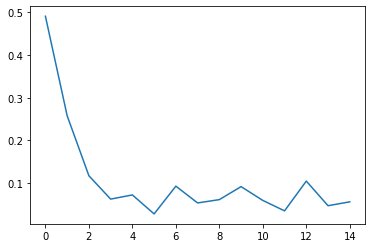

In [10]:
torch.cuda.empty_cache() #清除gpu缓存
fit(15)

在测试集上进行预测

In [11]:
validation()

Accuracy on testset: 0.858


0.8577712609970675

保存模型

In [ ]:
torch.save(model.state_dict(), 'models/model.pth')

附录:

此处展示了模型测试过程中使用过的双向LSTM模型与朴素的TextCNN模型

朴素的TextCNN模型

预测准确率 84.6%

In [ ]:
class OldTextCNN(nn.Module):
    def __init__(self, vocab_size = len(TEXT.vocab), pad_idx = TEXT.vocab.stoi[TEXT.pad_token], embedding_dim=300, hidden_dim=50, output_dim=9):
        super().__init__() #调用nn.Module的构造函数进行初始化
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx) #使用embedding table构建语句到向量的映射
        self.embedding.weight.data.copy_(weight_matrix) #载入由预训练词向量生成的权重矩阵
        self.fc1 = nn.Linear(embedding_dim, hidden_dim) #全连接层
        self.relu = nn.ReLU() #ReLU
        self.dropout = nn.Dropout(0.2) #dropout
        self.fc2 = nn.Linear(hidden_dim, output_dim) #全连接层
        
    def forward(self, text): #前向传播
        embedded = self.embedding(text)
        embedded = embedded.permute(1, 0, 2) #将batch_size移至第一维
        pooled = nn.functional.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) #对移至第二维的textlen进行average pooling获得二维张量(batch_size*embedding_dim)      
        droped = self.dropout(pooled)
        fced = self.fc1(droped)
        relued = self.relu(fced)
        droped = self.dropout(relued)
        y = self.fc2(droped) #通过全连接层处理获得预测类别
        return y

双向LSTM

预测准确率: 83.2%

In [ ]:
class LSTM(nn.Module):
    def __init__(self, dropout1=0.2, dropout2=0.2, bidirectional=True, hidden_size=200, num_layers=2):
        super(LSTM, self).__init__()
        self.word_embeddings = nn.Embedding(len(TEXT.vocab), 300)
        self.word_embeddings.weight.data.copy_(weight_matrix)
        self.lstm = nn.LSTM(input_size=300, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout1, bidirectional=bidirectional)
        self.dropout = nn.Dropout(dropout2)
        self.fc1 = nn.Linear(2*hidden_size, 50)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50,9)
        self.sigmoid = nn.Sigmoid()
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        _, (lstm_out, __) = self.lstm(embeds)
        last = torch.cat((lstm_out[-2,:,:], lstm_out[-1,:,:]), dim=1)
        fc1_in = self.dropout(last)
        fc1_out = self.fc1(fc1_in)
        fc2_in = self.relu(fc1_out)
        y = self.fc2(fc2_in)
        return y